# Project 3: Web APIs & NLP
---
Book 1: Data Collection<br>
Book 2: Data Cleaning & Exploratory Data Analysis<br>
Book 3: Preprocessing & Vectorization<br>
**Book 4: ML Modeling**<br>
Book 5: Sentiment Analysis, Conclusion & Recommendation<br>
Author: Lee Wan Xian

## Contents:
- [Data Model Preparation](#Data-Model-Preparation)
- [Modelling](#Modelling)
- [Model Evaluation](#Model-Evaluation)

## Python Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.pipeline import Pipeline

In [2]:
# this setting widens pandas column to fit 400 characters
pd.options.display.max_colwidth = 400

## Data Model Preparation

In [3]:
# Import corpus for modelling
df_corpus_clean = pd.read_csv('../data/df_corpus_model.csv')

In [4]:
# Drop documents that have no text after lemmatization
df_corpus_clean.dropna(subset=['full_text_lem'], inplace=True)

In [5]:
# Ensure that they are no more documents with missing value
df_corpus_clean.isna().sum()

subreddit         0
full_text         0
full_text_lem     0
full_text_stem    0
dtype: int64

In [6]:
# Replace the header name from `subreddit` to `is_netflix?`
df_corpus_clean = df_corpus_clean.rename(columns = {"subreddit": "is_netflix?"})

In [7]:
# Integer encoding the y-variable (is_netflix?) values
df_corpus_clean['is_netflix?'] = df_corpus_clean['is_netflix?'].map({'DisneyPlus': 0,
                                                                     'netflix':1
                                                                    })

Target y-variable encoded to:<br>
* `0` : DisneyPlus
* `1` : netflix

In [8]:
# show the proportion of DisneyPlus & Netflix posts in full corpus
print(df_corpus_clean['is_netflix?'].value_counts(normalize=True))

0    0.502661
1    0.497339
Name: is_netflix?, dtype: float64


The full corpus is well balanced with approximately equal proportion of DisneyPlus & Netflix.

In [9]:
print(df_corpus_clean.shape)
df_corpus_clean.info()
df_corpus_clean.head()

(29692, 4)
<class 'pandas.core.frame.DataFrame'>
Int64Index: 29692 entries, 0 to 29830
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   is_netflix?     29692 non-null  int64 
 1   full_text       29692 non-null  object
 2   full_text_lem   29692 non-null  object
 3   full_text_stem  29692 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.1+ MB


,is_netflix?,full_text,full_text_lem,full_text_stem
0,0,willow.... thought you were to be released today? [removed],willow thought released today,willow thought releas today
1,0,who’s excited?! [removed],excited,excit
2,0,"hocus pocus was a let down, thoughts? [removed]",hocus pocus let thought,hocu pocu let thought
3,0,friend made hocus pocus cookies!,friend made hocus pocus cooky,friend made hocu pocu cooki
4,0,hocus pocus - movie discussion thread as there wasn't one already thought i'd create one.,hocus pocus discussion thread one already thought create one,hocu pocu discuss thread one alreadi thought creat one


### Train-test split

In [10]:
# Set X-variable & y-variable
X = df_corpus_clean['full_text_lem']
y = df_corpus_clean['is_netflix?']

In [11]:
# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

## Modelling

### Baseline Model

As a baseline, we will use a Naive Bayes model coupled with Count vectorization. This model's metrics would be compared with that of other model combinations to pinpoint the best one for this binary classification problem. For feature consistency across all models testing, we will set the maximum limit of word features to 2500.

In [12]:
# instantiate CountVectorizer
cvec = CountVectorizer(max_features=2500)

# Transform X_train & X_test corpus
X_train_cvec = cvec.fit_transform(X_train)
X_test_cvec = cvec.transform(X_test)

In [13]:
# instantiate Naive Bayes model
nb = MultinomialNB()

# Fit into X_train corpus
baseline = nb.fit(X_train_cvec, y_train)

In [14]:
# Generate predictions from baseline
y_pred_base = baseline.predict(X_test_cvec)

In [15]:
# Baseline accuracy score
print(f'Baseline accuracy score (cross validated:k=5) on train set is {cross_val_score(baseline, X_train_cvec, y_train).mean()}')
print(f'Baseline accuracy score on test set is {baseline.score(X_test_cvec, y_test)}')

Baseline accuracy score (cross validated:k=5) on train set is 0.7675241415327134
Baseline accuracy score on test set is 0.7748888589519063


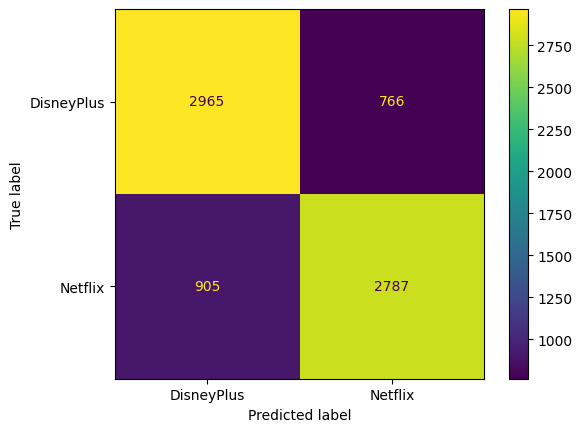

In [16]:
# Display confusion matrix for baseline model
cm = confusion_matrix(y_test, y_pred_base)

mat = ConfusionMatrixDisplay(confusion_matrix = cm,
                             display_labels = ['DisneyPlus', 'Netflix'])
mat.plot();

In [17]:
# Show classification metrics report for baseline model
print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.77      0.79      0.78      3731
           1       0.78      0.75      0.77      3692

    accuracy                           0.77      7423
   macro avg       0.78      0.77      0.77      7423
weighted avg       0.78      0.77      0.77      7423



#### Hyperparameter tuning on baseline

For this section, we will perform hyperparameter tuning to see whether is it possible to outperform the default parameters in baseline model.

In [18]:
# Instantiate Stop words from nltk
nltk_stopwords = stopwords.words("english")

# Define additional stop words
add_stop_wds = ['disney','disney+','plus','series','season','episode','streaming','shows','show','episodes','app','tv','netflix','movie','movies','account','r/netflix','r/disneyplus',
                'disneyplus','removed','a','b','c','d','e','f','g','h','i','j','k','l','m','n','o','p','q','r','s','t','u','v','w','x','y','z']

# create customized stop words list
cust_stop_wds = list(set(add_stop_wds + nltk_stopwords))

In [19]:
# Instantiate pipeline for NB model with Count Vectorization
basepipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [20]:
# Show the list of params available in pipeline
basepipe.get_params()

{'memory': None,
 'steps': [('cvec', CountVectorizer()), ('nb', MultinomialNB())],
 'verbose': False,
 'cvec': CountVectorizer(),
 'nb': MultinomialNB(),
 'cvec__analyzer': 'word',
 'cvec__binary': False,
 'cvec__decode_error': 'strict',
 'cvec__dtype': numpy.int64,
 'cvec__encoding': 'utf-8',
 'cvec__input': 'content',
 'cvec__lowercase': True,
 'cvec__max_df': 1.0,
 'cvec__max_features': None,
 'cvec__min_df': 1,
 'cvec__ngram_range': (1, 1),
 'cvec__preprocessor': None,
 'cvec__stop_words': None,
 'cvec__strip_accents': None,
 'cvec__token_pattern': '(?u)\\b\\w\\w+\\b',
 'cvec__tokenizer': None,
 'cvec__vocabulary': None,
 'nb__alpha': 1.0,
 'nb__class_prior': None,
 'nb__fit_prior': True}

In [21]:
# Define dictionary of hyperparameters for basepipe
basepipe_params = {
    'cvec__max_features': [1000, 1500, 2000, 2500],
    'cvec__ngram_range': [(1,1), (1,2), (2,2)],
    'cvec__stop_words': [None, cust_stop_wds]
}                

In [22]:
# Instantiate GridsearchCV model
baseline_grid = GridSearchCV(basepipe,
                             param_grid=basepipe_params,
                             cv=5,
                             n_jobs=-1
                            )

# fit the baseline grid model to train
baseline_grid.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=-1,
             param_grid={'cvec__max_features': [1000, 1500, 2000, 2500],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 2)],
                         'cvec__stop_words': [None,
                                              ['only', 'after', 'all', 'needn',
                                               'v', 'l', 'removed', 'did', 'i',
                                               'by', 't', "you're", "don't",
                                               'it', 'most', 'netflix', 'll',
                                               'y', 'between', 'g', 'my',
                                               'what', 'such', 'disney+',
                                               'plus', 'has', 'mightn', 'yours',
                                               'further', 'or', ...]]})

In [23]:
# Show best accuracy score for train
baseline_grid.best_score_

0.766581219343155

In [24]:
# Show the top 3 best scores with their params
pd.DataFrame(baseline_grid.cv_results_).sort_values('rank_test_score').head(3)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_cvec__max_features,param_cvec__ngram_range,param_cvec__stop_words,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
19,0.989779,0.113515,0.189809,0.014756,2500,"(1, 1)","[only, after, all, needn, v, l, removed, did, i, by, t, you're, don't, it, most, netflix, ll, y, between, g, my, what, such, disney+, plus, has, mightn, yours, further, or, wasn, before, he, shan, r, k, haven't, movie, shan't, ain, them, movies, few, should, against, ma, we, season, her, am, here, own, h, during, of, is, can, shouldn't, an, through, the, because, didn't, u, f, z, account, not,...","{'cvec__max_features': 2500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': ['only', 'after', 'all', 'needn', 'v', 'l', 'removed', 'did', 'i', 'by', 't', 'you're', 'don't', 'it', 'most', 'netflix', 'll', 'y', 'between', 'g', 'my', 'what', 'such', 'disney+', 'plus', 'has', 'mightn', 'yours', 'further', 'or', 'wasn', 'before', 'he', 'shan', 'r', 'k', 'haven't', 'movie', 'shan't', 'ain', 'them'...",0.765604,0.770768,0.757297,0.775483,0.763755,0.766581,0.006195,1
18,1.207823,0.239077,0.211041,0.038704,2500,"(1, 1)",None,"{'cvec__max_features': 2500, 'cvec__ngram_range': (1, 1), 'cvec__stop_words': None}",0.764706,0.770094,0.757746,0.775707,0.763081,0.766267,0.006148,2
20,3.389576,0.224885,0.275365,0.041220,2500,"(1, 2)",None,"{'cvec__max_features': 2500, 'cvec__ngram_range': (1, 2), 'cvec__stop_words': None}",0.766727,0.770768,0.763134,0.767176,0.760162,0.765593,0.003636,3


In [25]:
# Generate predictions from baseline_grid
y_pred_basegrid = baseline_grid.predict(X_test)

In [26]:
# Baseline accuracy score on Test set
print(f'Tuned baseline accuracy score on test set is {baseline_grid.score(X_test, y_test)}')

Tuned baseline accuracy score on test set is 0.7748888589519063


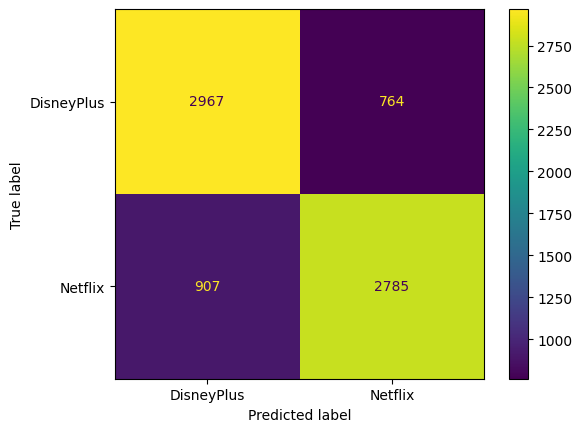

In [27]:
# Display confusion matrix for tuned baseline model
cm_grid = confusion_matrix(y_test, y_pred_basegrid)

mat = ConfusionMatrixDisplay(confusion_matrix = cm_grid,
                             display_labels = ['DisneyPlus', 'Netflix'])
mat.plot();

In [28]:
# Show classification metric report for tuned baseline model
print(classification_report(y_test, y_pred_basegrid))

              precision    recall  f1-score   support

           0       0.77      0.80      0.78      3731
           1       0.78      0.75      0.77      3692

    accuracy                           0.77      7423
   macro avg       0.78      0.77      0.77      7423
weighted avg       0.78      0.77      0.77      7423



### Other Models

As for other classification models, we will be using TF-IDF vectorization. Given that TF-IDF vectorization will focus on words that are neither the most frequent nor the least frequent, the word left will provide more signal than that of Count Vectorization. Words that occur often in one document but don't occur in many documents usually contain more predictive power. 

We will leverage on Pycaret to pinpoint the best performing models with their best parameters.
Documentation to Pycaret Classification ([Documentation](https://pycaret.gitbook.io/docs/)) for reference.

**Preparation for Pycaret Classification Setup**

In [29]:
from pycaret.classification import *

In [30]:
# TF-IDF Vectorize the X-Variable (full_text_lem)
tfvec = TfidfVectorizer(max_features=2500)

# Create train set for X
X_train_tfvec = pd.DataFrame(data = tfvec.fit_transform(X_train.values).todense(),
                             columns = tfvec.get_feature_names())

# Create test set for X
X_test_tfvec = pd.DataFrame(data = tfvec.transform(X_test.values).todense(),
                            columns = tfvec.get_feature_names())

In [31]:
# Concate the train set for X & y
df_pycar_train = pd.concat([X_train_tfvec, y_train.reset_index(drop=True)], axis=1)

In [32]:
# Define numeric_features
numeric_headers = list(df_pycar_train.columns)
numeric_headers = numeric_headers[:-1]          # To drop 'is_netflix?' from features

In [33]:
print(df_pycar_train.shape)
df_pycar_train.info()
df_pycar_train.head()

(22269, 2501)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22269 entries, 0 to 22268
Columns: 2501 entries, abc to is_netflix?
dtypes: float64(2500), int64(1)
memory usage: 424.9 MB


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,according,account,accurate,across,act,acting,action,activate,active,activity,actor,actress,actual,actually,ad,adam,adaptation,add,added,adding,addition,additional,address,adult,advance,advantage,adventure,advertising,advice,affect,africa,african,age,agent,ago,agree,ahead,ai,air,aired,airing,airplay,aka,aladdin,algorithm,alien,alive,allow,allowed,allows,almost,alone,along,alongside,alot,already,also,alt,alternative,although,alvar,alvin,always,amazing,amazon,america,american,among,amount,amphibia,ana,anatomy,andor,andrew,android,angel,angry,animal,animated,animation,anime,anna,anne,announced,announcement,annoyed,annoying,annual,another,answer,anthology,anthony,anti,anybody,anymore,anyone,anything,anytime,anyway,anyways,anywhere,apart,apparently,appear,appearance,appeared,appearing,appears,apple,application,apply,appreciate,appreciated,apps,april,arabic,arc,arcane,archive,area,army,around,arrive,art,article,artist,as,asia,asian,aside,ask,asked,asking,asks,asleep,aspect,assembled,assume,assuming,atleast,atmos,attached,attack,attempt,attention,attorney,au,audience,audio,august,australia,australian,author,auto,automatic,automatically,autoplay,availability,available,avatar,avenger,average,avoid,award,aware,away,awesome,awful,baby,back,background,bad,badly,balance,band,bank,banned,banner,bar,barely,base,based,basic,basically,basketball,batch,battle,bear,beast,beat,beatles,beautiful,beauty,bebop,became,become,becomes,becoming,bee,begin,beginning,behavior,behind,belgium,believe,bell,benedict,benefit,besides,best,bet,better,beyond,big,bigger,biggest,bill,billed,billing,billion,binge,binging,birthday,bit,bitch,bitrate,bizarre,black,blame,blank,blind,blinder,block,blockbuster,blocked,blocking,blonde,blood,blown,blu,...,tip,tired,titan,title,today,together,tokyo,told,tom,tommy,tomorrow,ton,tone,tonight,took,top,topic,total,totally,touch,towards,town,toy,track,trailer,train,transfer,translation,trash,travel,traveling,treasure,trend,trial,trick,tried,trigger,trilogy,trip,trouble,true,truly,trust,truth,try,trying,tudum,turkey,turkish,turn,turned,turner,turning,tv,twice,twin,twist,twitter,two,type,uhd,ui,uk,ukraine,ultimate,ultra,ultrawide,umbrella,un,unable,unavailable,uncharted,underrated,understand,understanding,unexpected,unfortunately,uninstalled,uninstalling,unique,united,universe,university,unknown,unless,unlike,unlimited,untold,unwatchable,upcoming,update,updated,updating,upgrade,upon,upset,upside,us,usa,usage,usd,use,used,useless,user,using,usual,usually,vacation,valhalla,value,vampire,variety,various,vecna,verizon,version,via,vibe,victim,victor,video,view,viewed,viewer,viewership,viewing,viking,villain,vintage,violence,vision,visit,visual,voice,volume,vote,vpn,wait,waiting,wake,walking,wall,wallpaper,walt,wan,wanda,wandavision,wanna,want,wanted,wanting,war,warning,waste,watch,watched,watchgroup,watching,watchlist,water,way,web,website,wedding,wednesday,week,weekend,weekly,weird,welcome,well,went,west,western,whatever,whats,whatsoever,whenever,whether,white,whoever,whole,wi,wide,widow,wife,wifi,wild,willing,wilson,wimpy,win,window,winner,winter,wish,witch,witcher,within,without,woke,wolf,woman,wonder,wondered,wonderful,wondering,wont,woo,wood,word,work,worked,working,world,worldwide,worried,worse,worst,worth,would,wow,wrapped,write,writer,writing,written,wrong,wrote,wtf,xb,xbox,xd,ya,yeah,year,yearly,yes,yesterday,yet,yo,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.588137,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

In [34]:
# Instantiate the setup for Pycaret Classification
pycar = setup(
    data = df_pycar_train,
    target = 'is_netflix?',                       # set y-variable as target
    numeric_features = numeric_headers,           # set features as numeric type
    fold = 5,                                     # No. of kfolds
    use_gpu = True,                               # Make use of GPU for processor intense models
    session_id = 123,                             # set a fixed random seed for result reproducility
    data_split_stratify = True,                   # retain the proportion of target during train-hold-out split
)    

,Description,Value
0,session_id,123
1,Target,is_netflix?
2,Target Type,Binary
3,Label Encoded,None
4,Original Data,"(22269, 2501)"
5,Missing Values,False
6,Numeric Features,2500
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


**Run comparison on model performance**

In [35]:
# Show the best performing models
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
et,Extra Trees Classifier,0.7854,0.8587,0.8026,0.7742,0.7881,0.5709,0.5713,24.4880
lr,Logistic Regression,0.7825,0.8698,0.8026,0.7699,0.7859,0.5651,0.5657,3.2400
ridge,Ridge Classifier,0.7780,0.0000,0.7962,0.7666,0.7811,0.5561,0.5566,1.1740
svm,SVM - Linear Kernel,0.7773,0.0000,0.8043,0.7622,0.7821,0.5546,0.5564,2.3060
rf,Random Forest Classifier,0.7708,0.8542,0.8115,0.7488,0.7789,0.5419,0.5439,16.7000
lightgbm,Light Gradient Boosting Machine,0.7676,0.8570,0.8300,0.7364,0.7803,0.5355,0.5399,2.2740
lda,Linear Discriminant Analysis,0.7648,0.8423,0.7780,0.7562,0.7669,0.5297,0.5299,21.8900
nb,Naive Bayes,0.7422,0.7981,0.6790,0.7749,0.7237,0.4841,0.4879,0.9060
dt,Decision Tree Classifier,0.7229,0.7307,0.7361,0.7152,0.7254,0.4458,0.4460,29.5580
gbc,Gradient Boosting Classifier,0.7048,0.7922,0.9119,0.6434,0.7545,0.4110,0.4515,38.4440


We will evaluate the below 5 classification models
* Extra Trees Classifier
* Logistic Regression
* SVM - Linear Kernel
* Random Forest Classifier
* Naive Bayes

Even though Ada Boost Classifier has a high recall score, its accuracy is quite poor in comparison. For this problem, the predictions on `DisneyPlus` is also important and accuracy metric is needed for such assessment.

#### Create models

In [36]:
et = create_model('et')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7919,0.8633,0.8155,0.7769,0.7957,0.5838,0.5845
1,0.7867,0.8574,0.7969,0.7793,0.7880,0.5735,0.5736
2,0.7957,0.8650,0.8098,0.7860,0.7977,0.5915,0.5917
3,0.7751,0.8494,0.7981,0.7612,0.7792,0.5503,0.5510
4,0.7777,0.8585,0.7929,0.7676,0.7801,0.5554,0.5557
Mean,0.7854,0.8587,0.8026,0.7742,0.7881,0.5709,0.5713
Std,0.0079,0.0055,0.0085,0.0088,0.0077,0.0159,0.0158


In [37]:
lr = create_model('lr')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7861,0.8763,0.8148,0.7687,0.7911,0.5723,0.5733
1,0.7832,0.8631,0.7924,0.7764,0.7843,0.5664,0.5665
2,0.7797,0.8741,0.8014,0.7663,0.7835,0.5594,0.5600
3,0.7786,0.8634,0.8026,0.7641,0.7829,0.5574,0.5581
4,0.7850,0.8722,0.8019,0.7740,0.7877,0.5702,0.5705
Mean,0.7825,0.8698,0.8026,0.7699,0.7859,0.5651,0.5657
Std,0.0029,0.0055,0.0072,0.0046,0.0031,0.0059,0.0059


In [38]:
svm = create_model('svm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7797,0.0000,0.7671,0.7848,0.7759,0.5593,0.5594
1,0.7787,0.0000,0.7847,0.7737,0.7791,0.5574,0.5575
2,0.7809,0.0000,0.8337,0.7526,0.7911,0.5621,0.5654
3,0.7664,0.0000,0.8323,0.7338,0.7799,0.5332,0.5380
4,0.7806,0.0000,0.8039,0.7663,0.7846,0.5612,0.5619
Mean,0.7773,0.0000,0.8043,0.7622,0.7821,0.5546,0.5564
Std,0.0055,0.0000,0.0261,0.0177,0.0053,0.0108,0.0096


In [39]:
rf = create_model('rf')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7729,0.8579,0.8265,0.7448,0.7835,0.5461,0.5494
1,0.7713,0.8533,0.7969,0.7564,0.7761,0.5428,0.5435
2,0.7826,0.8635,0.8240,0.7594,0.7904,0.5653,0.5673
3,0.7613,0.8454,0.8052,0.7385,0.7704,0.5228,0.5250
4,0.7658,0.8507,0.8052,0.7446,0.7737,0.5318,0.5335
Mean,0.7708,0.8542,0.8115,0.7487,0.7788,0.5418,0.5438
Std,0.0072,0.0062,0.0116,0.0079,0.0072,0.0144,0.0145


In [40]:
nb = create_model('nb')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7463,0.7983,0.6948,0.7720,0.7314,0.4923,0.4948
1,0.7434,0.7945,0.6912,0.7696,0.7283,0.4866,0.4891
2,0.7434,0.8045,0.6718,0.7817,0.7226,0.4865,0.4913
3,0.7308,0.7892,0.6665,0.7624,0.7112,0.4613,0.4649
4,0.7472,0.8040,0.6710,0.7891,0.7252,0.4940,0.4995
Mean,0.7422,0.7981,0.6790,0.7749,0.7237,0.4841,0.4879
Std,0.0059,0.0058,0.0116,0.0094,0.0069,0.0118,0.0120


#### Hyperparameter tuning on models

In [41]:
tuned_et = tune_model(et, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7207,0.8223,0.8942,0.6622,0.7609,0.4424,0.4718
1,0.7213,0.8116,0.8756,0.6676,0.7576,0.4435,0.4663
2,0.7322,0.8229,0.9033,0.6716,0.7704,0.4653,0.4953
3,0.7183,0.8059,0.8787,0.6637,0.7562,0.4376,0.4622
4,0.7055,0.8061,0.6168,0.7469,0.6756,0.4104,0.4167
Mean,0.7196,0.8138,0.8337,0.6824,0.7442,0.4398,0.4625
Std,0.0085,0.0075,0.1089,0.0324,0.0346,0.0176,0.0256


In [42]:
# Show hyperparameters of tuned Extra Trees Classifier
print(tuned_et)

ExtraTreesClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                     criterion='gini', max_depth=None, max_features='auto',
                     max_leaf_nodes=None, max_samples=None,
                     min_impurity_decrease=0.0, min_impurity_split=None,
                     min_samples_leaf=1, min_samples_split=2,
                     min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
                     oob_score=False, random_state=123, verbose=0,
                     warm_start=False)


In [43]:
tuned_lr = tune_model(lr, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7880,0.8775,0.8103,0.7739,0.7917,0.5761,0.5767
1,0.7877,0.8652,0.7937,0.7826,0.7881,0.5754,0.5754
2,0.7861,0.8759,0.8046,0.7742,0.7891,0.5722,0.5727
3,0.7713,0.8646,0.7910,0.7591,0.7747,0.5426,0.5431
4,0.7854,0.8732,0.8019,0.7745,0.7880,0.5708,0.5712
Mean,0.7837,0.8713,0.8003,0.7728,0.7863,0.5674,0.5678
Std,0.0063,0.0054,0.0071,0.0076,0.0059,0.0126,0.0125


In [44]:
# Show hyperparameters of tuned Logistic Regression
print(tuned_lr)

LogisticRegression(C=3.882, class_weight={}, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=1000,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=123, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)


In [45]:
tuned_svm = tune_model(svm, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7659,0.0000,0.7916,0.7509,0.7707,0.5319,0.5327
1,0.7681,0.0000,0.7685,0.7661,0.7673,0.5362,0.5362
2,0.7771,0.0000,0.7950,0.7658,0.7801,0.5543,0.5547
3,0.7655,0.0000,0.7794,0.7564,0.7677,0.5310,0.5313
4,0.7626,0.0000,0.7761,0.7538,0.7648,0.5252,0.5255
Mean,0.7678,0.0000,0.7821,0.7586,0.7701,0.5357,0.5361
Std,0.0050,0.0000,0.0098,0.0063,0.0053,0.0099,0.0099


In [46]:
# Show hyperparameters of tuned SVM
print(tuned_svm)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.001, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=-1, penalty='l2',
              power_t=0.5, random_state=123, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)


In [47]:
tuned_rf = tune_model(rf, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.6956,0.7923,0.5916,0.7437,0.6590,0.3905,0.3989
1,0.6786,0.7857,0.5326,0.7489,0.6225,0.3563,0.3721
2,0.6972,0.7935,0.5919,0.7469,0.6604,0.3938,0.4025
3,0.6859,0.7804,0.5600,0.7451,0.6394,0.3710,0.3829
4,0.6866,0.7815,0.5542,0.7502,0.6375,0.3722,0.3855
Mean,0.6888,0.7867,0.5660,0.7470,0.6438,0.3768,0.3884
Std,0.0068,0.0054,0.0229,0.0024,0.0143,0.0138,0.0111


In [48]:
# Show hyperparameters of tuned Random Forest Classifier
print(tuned_rf)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=123, verbose=0,
                       warm_start=False)


In [49]:
tuned_nb = tune_model(nb, choose_better=True)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.7749,0.8526,0.8310,0.7454,0.7858,0.5500,0.5536
1,0.7636,0.8366,0.7930,0.7473,0.7695,0.5274,0.5284
2,0.7723,0.8481,0.8021,0.7553,0.7780,0.5447,0.5457
3,0.7565,0.8411,0.7916,0.7378,0.7638,0.5132,0.5145
4,0.7713,0.8453,0.8065,0.7517,0.7781,0.5427,0.5441
Mean,0.7677,0.8448,0.8048,0.7475,0.7750,0.5356,0.5373
Std,0.0067,0.0055,0.0142,0.0059,0.0077,0.0135,0.0140


In [50]:
# Show hyperparameters of tuned Naive Bayes
print(tuned_nb)

GaussianNB(priors=None, var_smoothing=1)


#### Metrics on Tuned models

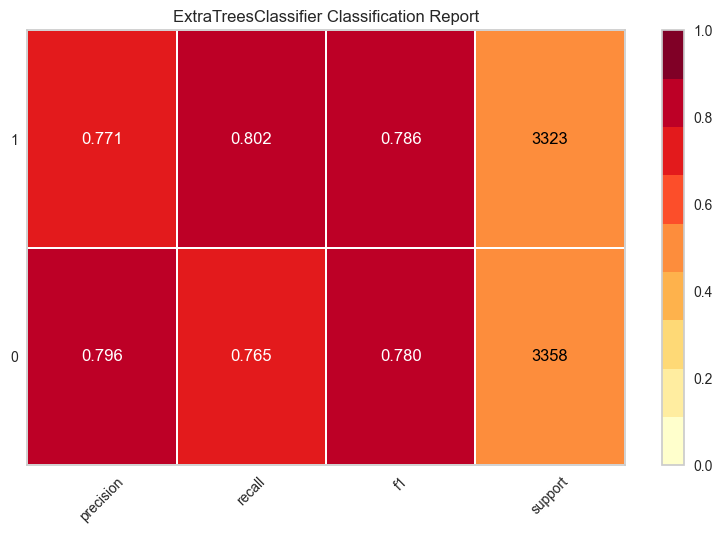

In [51]:
plot_model(tuned_et, plot='class_report')

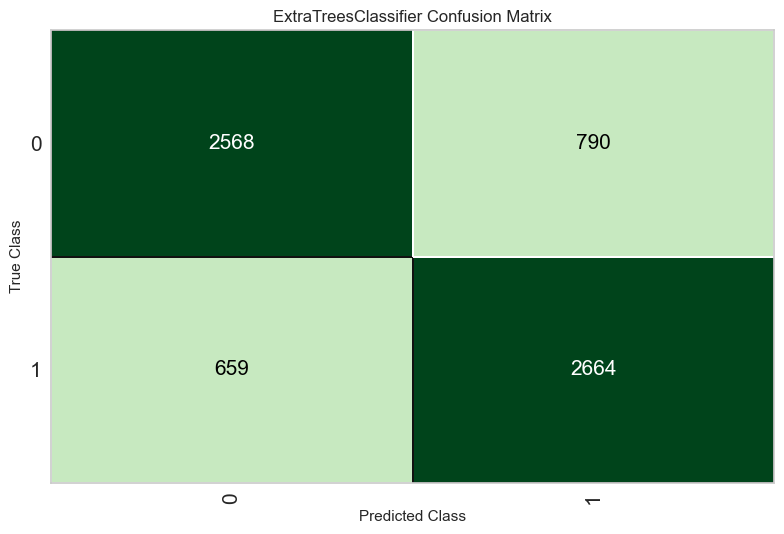

In [52]:
plot_model(tuned_et, plot='confusion_matrix')

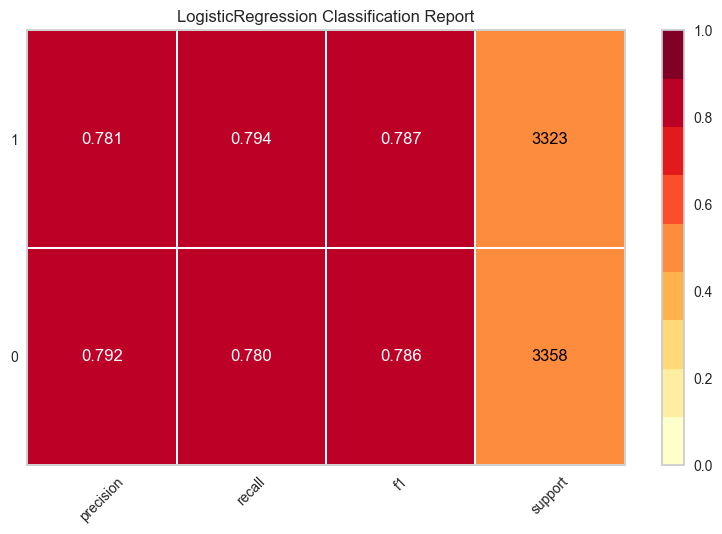

In [53]:
plot_model(tuned_lr, plot='class_report')

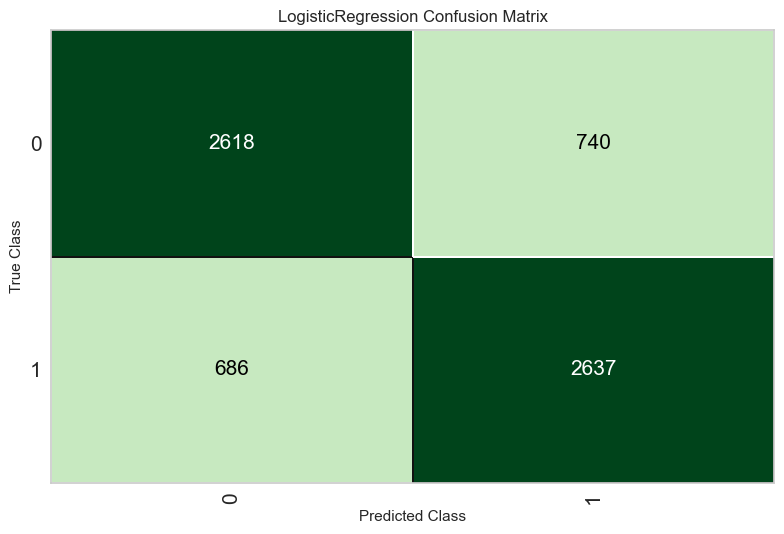

In [54]:
plot_model(tuned_lr, plot='confusion_matrix')

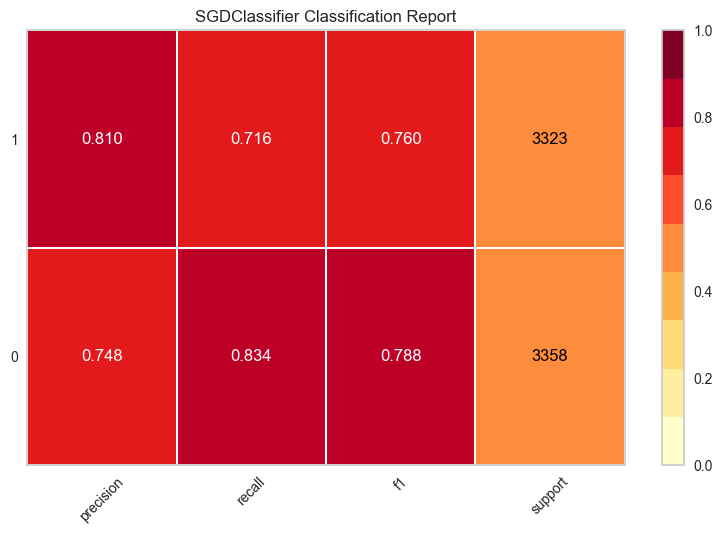

In [55]:
plot_model(tuned_svm, plot='class_report')

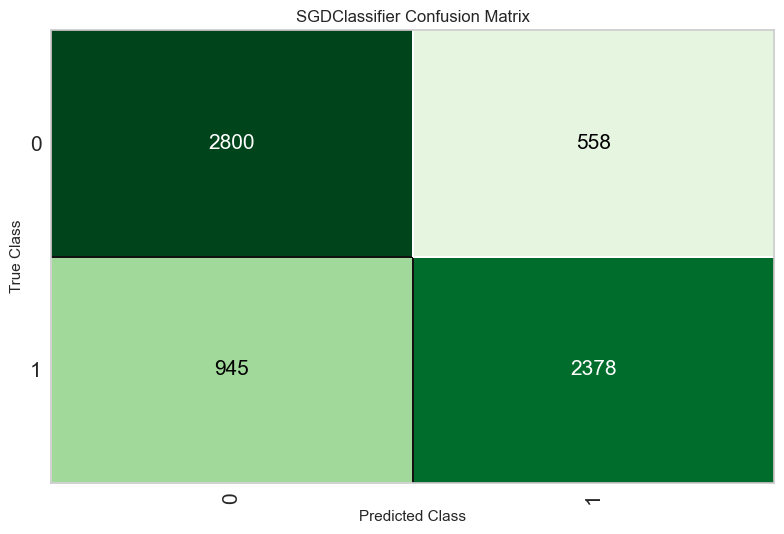

In [56]:
plot_model(tuned_svm, plot='confusion_matrix')

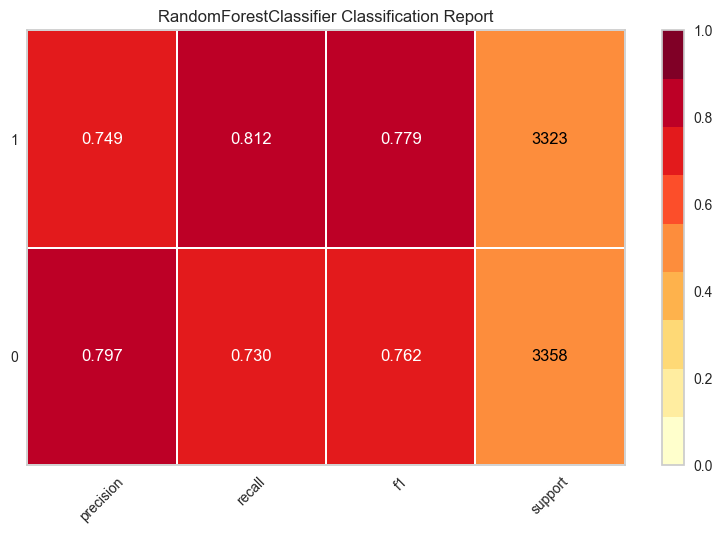

In [57]:
plot_model(tuned_rf, plot='class_report')

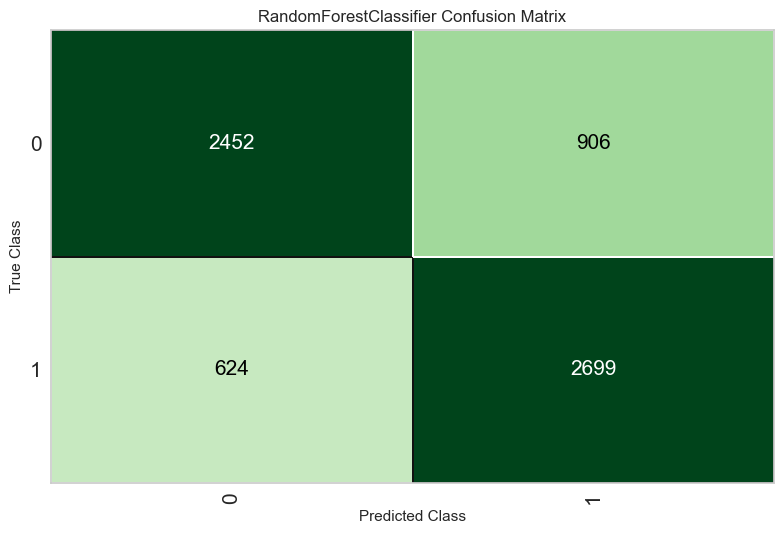

In [58]:
plot_model(tuned_rf, plot='confusion_matrix')

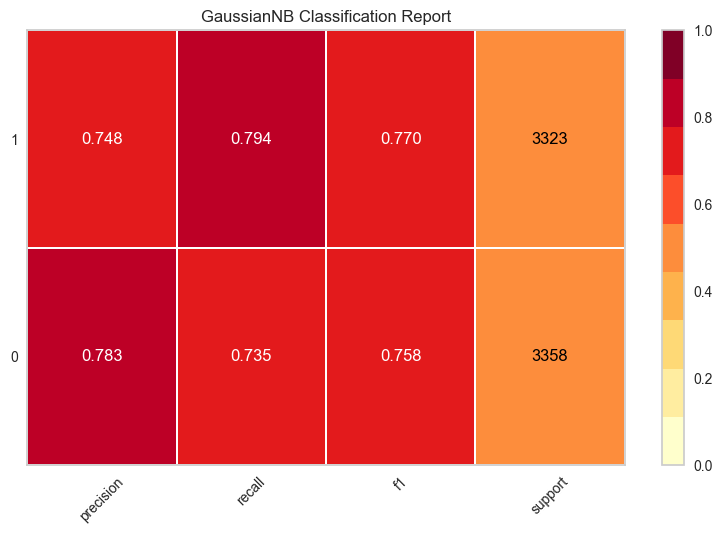

In [59]:
plot_model(tuned_nb, plot='class_report')

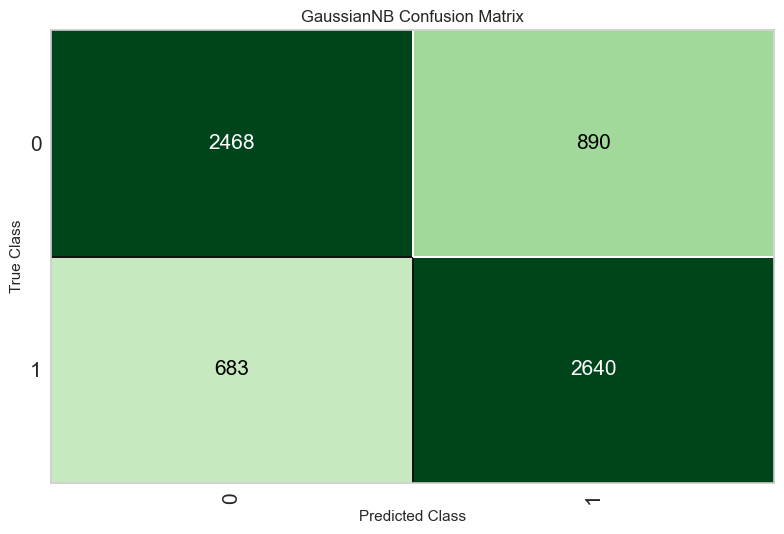

In [60]:
plot_model(tuned_nb, plot='confusion_matrix')

In [61]:
# Specificity metrics
print(f'Specificity of et model: {round(2568/(2568+790),3)}')
print(f'Specificity of lr model: {round(2618/(2618+740),3)}')
print(f'Specificity of svm model: {round(2800/(2800+558),3)}')
print(f'Specificity of rf model: {round(2452/(2452+906),3)}')
print(f'Specificity of nb model: {round(2468/(2468+890),3)}')

Specificity of et model: 0.765
Specificity of lr model: 0.78
Specificity of svm model: 0.834
Specificity of rf model: 0.73
Specificity of nb model: 0.735


#### Predictions

**Run prediction on hold-out sample**

In [62]:
predict_model(tuned_et)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7831,0.8623,0.8017,0.7713,0.7862,0.5663,0.5667


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7400
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9375
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9400
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7542
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.8600
6677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9332
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.7126
6679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7200


In [63]:
predict_model(tuned_lr)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7866,0.8762,0.7936,0.7809,0.7872,0.5731,0.5732


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8682
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9528
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9679
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6178
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9176
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.6260
6677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9926
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6183
6679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6737


In [64]:
predict_model(tuned_svm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7750,0.7747,0.7156,0.8099,0.7599,0.5498,0.5535


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yo,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?,Label
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
6677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0
6679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0


In [65]:
predict_model(tuned_rf)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7710,0.8559,0.8122,0.7487,0.7792,0.5422,0.5441


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6660
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9392
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9800
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.6160
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.8500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9568
6677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9132
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.6905
6679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.7600


In [66]:
predict_model(tuned_nb)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7646,0.8451,0.7945,0.7479,0.7705,0.5293,0.5303


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?,Label,Score
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9994
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,1.0000
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8625
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9998
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6676,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0.9998
6677,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,1.0000
6678,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0.8632
6679,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,1,0.9735


**Finalize the models**

In [67]:
final_et = finalize_model(tuned_et)

In [68]:
final_lr = finalize_model(tuned_lr)

In [69]:
final_svm = finalize_model(tuned_svm)

In [70]:
final_rf = finalize_model(tuned_rf)

In [71]:
final_nb = finalize_model(tuned_nb)

**Run prediction on Test set**

In [72]:
# Concate the test set for X & y
df_pycar_test = pd.concat([X_test_tfvec, y_test.reset_index(drop=True)], axis=1)

In [73]:
print(df_pycar_test.shape)
df_pycar_test.info()
df_pycar_test.head()

(7423, 2501)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7423 entries, 0 to 7422
Columns: 2501 entries, abc to is_netflix?
dtypes: float64(2500), int64(1)
memory usage: 141.6 MB


,abc,ability,able,absolute,absolutely,academy,acc,accent,access,accidentally,...,yet,yo,yonder,young,younger,youtube,zealand,zero,zombie,is_netflix?
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [74]:
y_pred_et = predict_model(final_et, data=df_pycar_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Extra Trees Classifier,0.7925,0.8673,0.7990,0.7871,0.7930,0.5851,0.5852


In [75]:
y_pred_lr = predict_model(final_lr, data=df_pycar_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Logistic Regression,0.7950,0.8811,0.8077,0.7860,0.7967,0.5900,0.5902


In [76]:
y_pred_svm = predict_model(final_svm, data=df_pycar_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,SVM - Linear Kernel,0.7916,0.7920,0.8608,0.7547,0.8043,0.5835,0.5893


In [77]:
y_pred_rf = predict_model(final_rf, data=df_pycar_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Random Forest Classifier,0.7792,0.8633,0.8034,0.7646,0.7835,0.5585,0.5592


In [78]:
y_pred_nb = predict_model(final_nb, data=df_pycar_test)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Naive Bayes,0.7770,0.8522,0.7950,0.7657,0.7801,0.5542,0.5546


## Model Evaluation

Model|Vectorization|Accuracy (Train)|Accuracy (Test)
---|---|---|---
Naive Bayes (Baseline)|Count|0.7675|0.7748
Naive Bayes (Tuned)|Count|0.7665|0.7748
Extra Trees Classifier|TF-IDF|0.7196|0.7925
**Logistic Regression**|**TF-IDF**|**0.7837**|**0.7950**
SVM-Linear Kernel|TF-IDF|0.7678|0.7916|0.7916
Random Forest Classifier|TF-IDF|0.6888|0.7792
Naive Bayes|TF-IDF|0.7677|0.7770

For this classification problem, **accuracy score** is the most important metric. The model should be predict both DisneyPlus and Netflix posts as accurate as possible. In view of this, we will compare the accuracy score for all 7 models done in both training and test data.<br>

From the table above, the baseline model performed quite well in general (accuracy score was well above 0.5). The accuracy score in train set is lower than that of test set with a difference of around 0.01. This shows that the model is neither overfitted nor underfitted. It is noted that all of these models do not show signs of overfitting since all of their accuracy (test) scores are higher than accuracy (train) scores.<br>

Logistic Regression model with TF-IDF vectorization performed the best out of the 7 models. Even though accuracy (test) scores are similar amongst logistic regression, extra trees classifier and SVM-linear kernel models, the accuracy (train) score of logistic regression (0.7837) is significantly higher than the rest.

Model|Accuracy|F1 score|Recall|Precision|Specificity|AUC
---|---|---|---|---|---|---
**Logistic Regression**|**0.783**|**0.787**|**0.794**|**0.781**|**0.780**|0.871
SVM-Linear Kernel|0.767|0.760|0.716|0.810|0.834|0.000
Extra Trees Classifier|0.719|0.786|0.802|0.771|0.765|0.813

Considering all other metrics, the overall metrics for Logistic Regression model is the most balanced. All of them are at least above 0.75 and the variance across all these metrics is very small (less than 0.01). There is a very high likelihood that the logistic regression model fits well with the data on hand and still be able to fit well in unseen data. This means that Logistic Regression is able to predict the correct streaming service to the post for both DisneyPlus and Netflix with an accuracy of 0.783.

A limitation of Logistic Regression is that it assumes the features have at most moderate multicollinearity with each other in order to perform well. This might be hard to achieve with text words in real world scenario.

**Please proceed to Book 5 for Sentiment Analysis, Conclusion & Recommendation**